In [1]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.metrics import roc_curve, roc_auc_score,classification_report,precision_score,accuracy_score,confusion_matrix,recall_score, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
# Load data into dataframe
churn_data = pd.read_csv("churn_data.csv")
churn_data.info()
churn_data.head(5)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


# Data exploration and Visualization

No     5174
Yes    1869
Name: Churn, dtype: int64


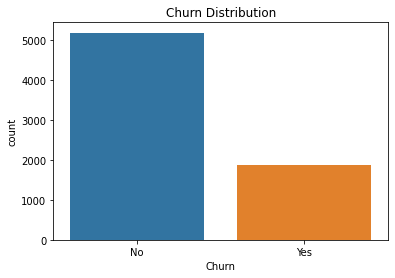

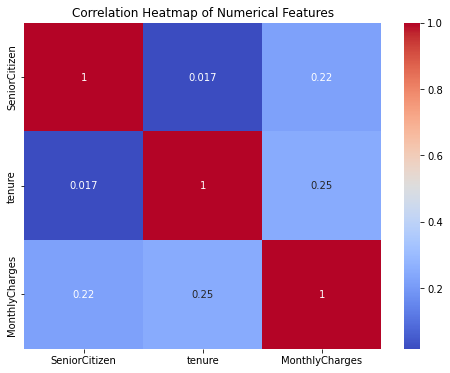

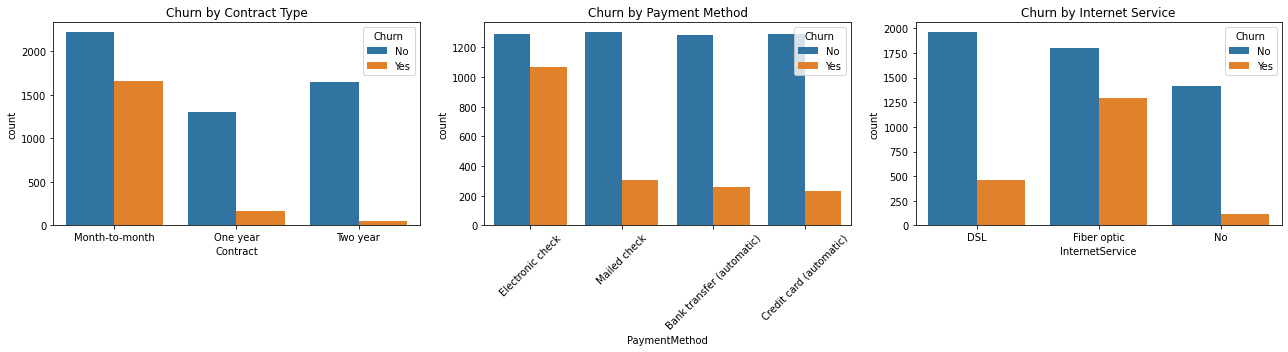

In [3]:

#data visualization for outpout label Churn
print(churn_data['Churn'].value_counts())
sns.countplot(data=churn_data, x='Churn')
plt.title('Churn Distribution')
plt.show()

# Calculate the correlation matrix
correlation_matrix = churn_data.corr()
#print(f "Correlation Matrix:  {correlation_matrix}")

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap of Numerical Features')
plt.show()


#Visualize churn rate by contract type, payment method, and internet service
plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
sns.countplot(data=churn_data, x='Contract', hue='Churn')
plt.title('Churn by Contract Type')

plt.subplot(1, 3, 2)
sns.countplot(data=churn_data, x='PaymentMethod', hue='Churn')
plt.title('Churn by Payment Method')
plt.xticks(rotation=45)

plt.subplot(1, 3, 3)
sns.countplot(data=churn_data, x='InternetService', hue='Churn')
plt.title('Churn by Internet Service')

plt.tight_layout()
plt.show()

# Data Preprocessing

In [4]:
# Check for missing values and empty strings

'''
missing_counts = churn_data.isnull().sum()
print(f"missing_counts  : {missing_counts}")
empty_counts = (churn_data == ' ').sum()
print(f"count of empty values {empty_counts}")
'''

# handle missing values
churn_data['TotalCharges'] = pd.to_numeric(churn_data['TotalCharges'], errors='coerce')
churn_data['TotalCharges'].fillna(churn_data['TotalCharges'].median(), inplace=True)

# Encode target value
churn_data['Churn'] = churn_data['Churn'].map({'No': 0, 'Yes': 1})


# Drop columns not needed
churn_data.drop(['customerID'], axis=1, inplace=True)

#one hot encoding for all catagorial values

churn_data = pd.get_dummies(churn_data, columns=[
    'gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
    'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
    'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract',
    'PaperlessBilling', 'PaymentMethod'
], drop_first=True)

churn_data.info()
#churn_data.head()

# Identify numerical columns to scale
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']


# Scale numerical columns
scaler = StandardScaler()
churn_data[num_cols] = scaler.fit_transform(churn_data[num_cols])

churn_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 31 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   SeniorCitizen                          7043 non-null   int64  
 1   tenure                                 7043 non-null   int64  
 2   MonthlyCharges                         7043 non-null   float64
 3   TotalCharges                           7043 non-null   float64
 4   Churn                                  7043 non-null   int64  
 5   gender_Male                            7043 non-null   uint8  
 6   Partner_Yes                            7043 non-null   uint8  
 7   Dependents_Yes                         7043 non-null   uint8  
 8   PhoneService_Yes                       7043 non-null   uint8  
 9   MultipleLines_No phone service         7043 non-null   uint8  
 10  MultipleLines_Yes                      7043 non-null   uint8  
 11  Inte

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,0,-1.277445,-1.160323,-0.994242,0,0,1,0,0,1,...,0,0,0,0,0,0,1,0,1,0
1,0,0.066327,-0.259629,-0.173244,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,1
2,0,-1.236724,-0.362660,-0.959674,1,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,1
3,0,0.514251,-0.746535,-0.194766,0,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
4,0,-1.236724,0.197365,-0.940470,1,0,0,0,1,0,...,0,0,0,0,0,0,1,0,1,0


## Test split

In [5]:
X = churn_data.drop('Churn', axis=1)
y = churn_data['Churn']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Model Training 

In [6]:
# Store metrics
metrics = {
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1-score": [],
    "ROC-AUC-score": []
}
model_names = []

AUC = []

#display confusion matrix
def showConfMatrix(model_name, y_test, y_pred) : 
    conf_matrix = confusion_matrix(y_test, y_pred)
    #conf_matrix = np.array([[927, 108], [166, 208]])
    # Labels for the axes
    labels = ['No Churn', 'Churn']
    # Create the heatmap
    plt.figure(figsize=(6, 5))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels, cbar=True)
    # Add axis labels and title
    plt.xlabel('Predicted Label')
    plt.ylabel('Actual Label')
    plt.title("Confusion Matrix - :" + model_name)
    # Show the plot
    plt.tight_layout()
    plt.show()
def showMetrics(model_name, y_test, y_pred) :
  
    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("Precision :", precision_score(y_test, y_pred))
    print("Recall :", recall_score(y_test, y_pred))
    print("F1-score :", f1_score(y_test, y_pred))
    #print("ROC-AUC score :", roc_auc_score(y_test, y_proba))
    
def showROC(y_proba,y_test):
    #y_proba = log_reg.predict_proba(X_test)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_test, y_proba)
    roc_auc = roc_auc_score(y_test, y_proba)
    print(f"roc-auc score : {roc_auc}")
    # Plot ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--', label='Random guess')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()
    

## Logistic regression

Accuracy : 0.8055358410220014
Precision : 0.6582278481012658
Recall : 0.5561497326203209
F1-score : 0.6028985507246376


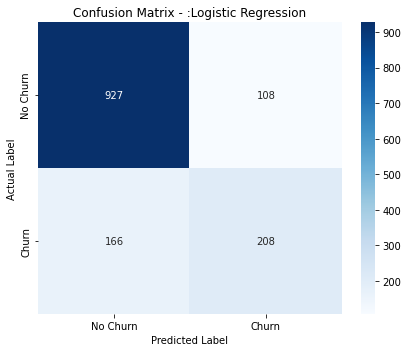

roc-auc score : 0.8419979849647369


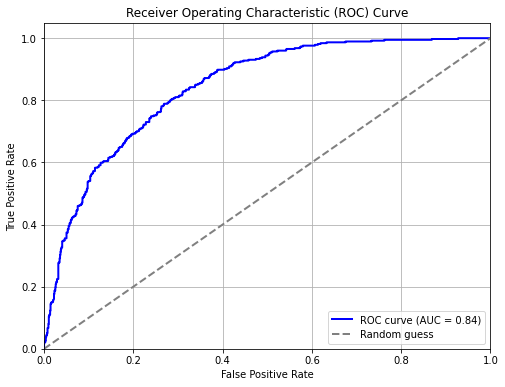

In [7]:
model_names.append("Logistic Regression")
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

#evaluate
y_pred = log_reg.predict(X_test)
y_proba = log_reg.predict_proba(X_test)[:, 1]
#print(f"Classification report :  {classification_report(y_test, y_pred)}")
# append to metrics for model comparison
metrics["Accuracy"].append(accuracy_score(y_test, y_pred))
metrics["Precision"].append(precision_score(y_test, y_pred))
metrics["Recall"].append(recall_score(y_test, y_pred))
metrics["F1-score"].append(f1_score(y_test, y_pred))
metrics["ROC-AUC-score"].append(roc_auc_score(y_test, y_proba))
AUC.append(["Logistic Regression",y_proba])

showMetrics("Logistic Regression", y_test, y_pred)
showConfMatrix("Logistic Regression", y_test, y_pred)
showROC(y_proba,y_test)

## Decision tree

Accuracy : 0.7366926898509581
Precision : 0.5041322314049587
Recall : 0.4893048128342246
F1-score : 0.49660786974219806


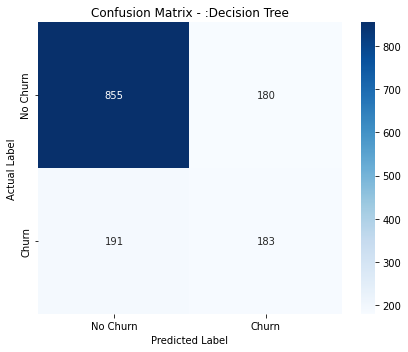

roc-auc score : 0.6572024593763724


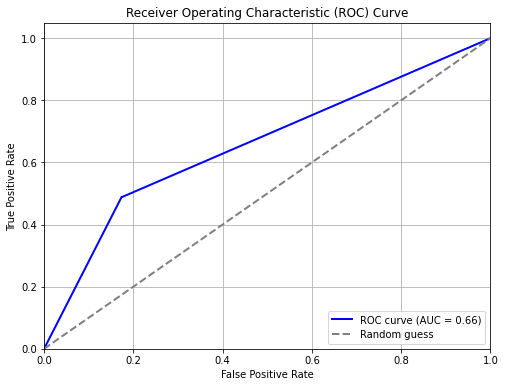

In [8]:
model_names.append("Decision Tree")
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

#evaluate
y_pred = dt.predict(X_test)
y_proba = dt.predict_proba(X_test)[:, 1]
# append to metrics for model comparison
metrics["Accuracy"].append(accuracy_score(y_test, y_pred))
metrics["Precision"].append(precision_score(y_test, y_pred))
metrics["Recall"].append(recall_score(y_test, y_pred))
metrics["F1-score"].append(f1_score(y_test, y_pred))
metrics["ROC-AUC-score"].append(roc_auc_score(y_test, y_proba))
AUC.append(["Decision Tree",y_proba])
#Display results
showMetrics("Decision Tree", y_test, y_pred)
showConfMatrix("Decision Tree", y_test, y_pred)
showROC(y_proba,y_test)

## Random Forest

Accuracy : 0.7877927608232789
Precision : 0.6262626262626263
Recall : 0.49732620320855614
F1-score : 0.5543964232488823


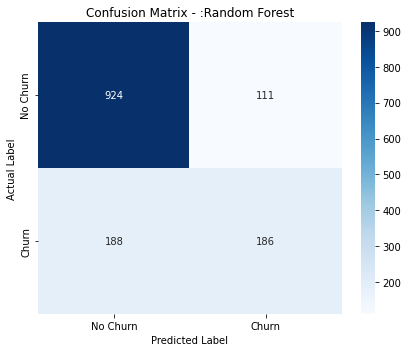

roc-auc score : 0.8249670619235836


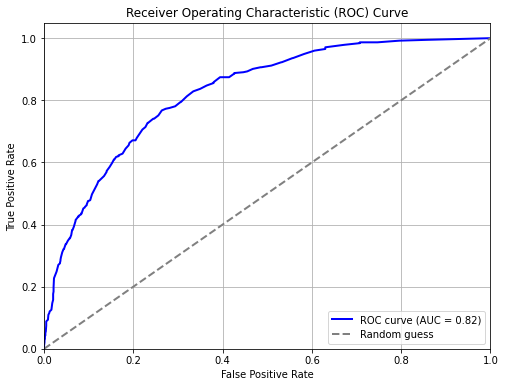

In [9]:
model_names.append("Random Forest")
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
#evaluate
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]
# append to metrics for model comparison
metrics["Accuracy"].append(accuracy_score(y_test, y_pred))
metrics["Precision"].append(precision_score(y_test, y_pred))
metrics["Recall"].append(recall_score(y_test, y_pred))
metrics["F1-score"].append(f1_score(y_test, y_pred))
metrics["ROC-AUC-score"].append(roc_auc_score(y_test, y_proba))
AUC.append(["Random Forest",y_proba])

#Display results
showMetrics("Random Forest", y_test, y_pred)
showConfMatrix("Random Forest", y_test, y_pred)
showROC(y_proba,y_test)

##  Gradient Boosting

Accuracy : 0.7984386089425124
Precision : 0.6530612244897959
Recall : 0.5133689839572193
F1-score : 0.5748502994011976


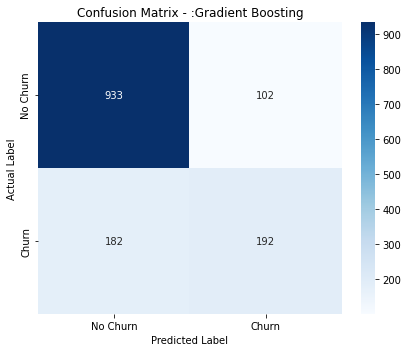

roc-auc score : 0.8425146606732284


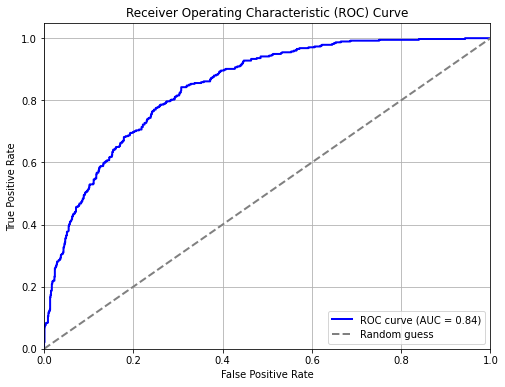

In [10]:
model_names.append("Gradient Boosting")
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)
#evaluate
y_pred = gb.predict(X_test)
y_proba = gb.predict_proba(X_test)[:, 1]
# append to metrics for model comparison
metrics["Accuracy"].append(accuracy_score(y_test, y_pred))
metrics["Precision"].append(precision_score(y_test, y_pred))
metrics["Recall"].append(recall_score(y_test, y_pred))
metrics["F1-score"].append(f1_score(y_test, y_pred))
metrics["ROC-AUC-score"].append(roc_auc_score(y_test, y_proba))
AUC.append(["Gradient Boosting",y_proba])
#Display results
showMetrics("Gradient Boosting", y_test, y_pred)
showConfMatrix("Gradient Boosting", y_test, y_pred)
showROC(y_proba,y_test)

## SVM

Accuracy : 0.794889992902768
Precision : 0.6545454545454545
Recall : 0.48128342245989303
F1-score : 0.5546995377503853


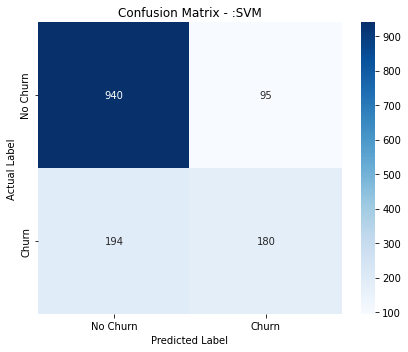

roc-auc score : 0.7949430365031389


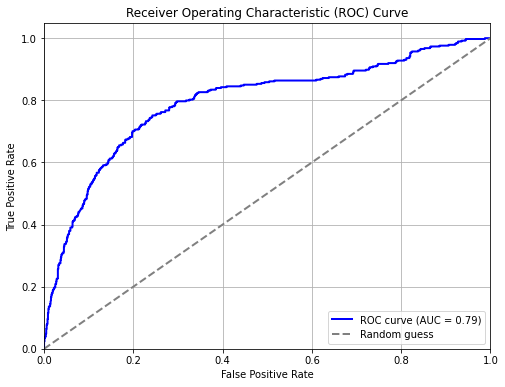

In [11]:
model_names.append("SVM")
svm = SVC(probability=True)
svm.fit(X_train, y_train)
#evaluate
y_pred = svm.predict(X_test)
y_proba = svm.predict_proba(X_test)[:, 1]
# append to metrics for model comparison
metrics["Accuracy"].append(accuracy_score(y_test, y_pred))
metrics["Precision"].append(precision_score(y_test, y_pred))
metrics["Recall"].append(recall_score(y_test, y_pred))
metrics["F1-score"].append(f1_score(y_test, y_pred))
metrics["ROC-AUC-score"].append(roc_auc_score(y_test, y_proba))
AUC.append(["SVM",y_proba])
#Display results
showMetrics("SVM", y_test, y_pred)
showConfMatrix("SVM", y_test, y_pred)
showROC(y_proba,y_test)

## XGB Classifier

Accuracy : 0.7970191625266146
Precision : 0.6506849315068494
Recall : 0.5080213903743316
F1-score : 0.5705705705705707


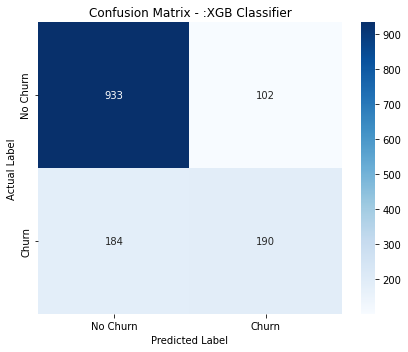

roc-auc score : 0.843318091399933


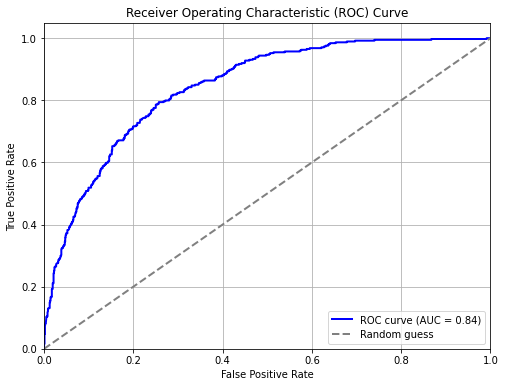

In [12]:
model_names.append("XGB Classifier")
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb_model.fit(X_train, y_train)
#evaluate
y_pred = xgb_model.predict(X_test)
y_proba = xgb_model.predict_proba(X_test)[:, 1]
# append to metrics for model comparison
metrics["Accuracy"].append(accuracy_score(y_test, y_pred))
metrics["Precision"].append(precision_score(y_test, y_pred))
metrics["Recall"].append(recall_score(y_test, y_pred))
metrics["F1-score"].append(f1_score(y_test, y_pred))
metrics["ROC-AUC-score"].append(roc_auc_score(y_test, y_proba))
AUC.append(["XGB Classifier",y_proba])
#Display results
showMetrics("XGB Classifier", y_test, y_pred)
showConfMatrix("XGB Classifier", y_test, y_pred)
showROC(y_proba,y_test)

# Model Comparision

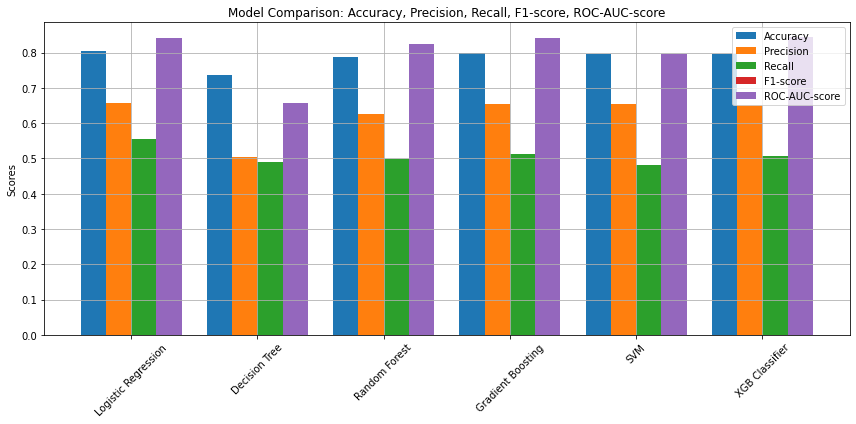

In [13]:
# Plot grouped bar chart
x = np.arange(len(model_names))  # label locations
width = 0.2  # width of the bars

fig, ax = plt.subplots(figsize=(12, 6))
rects1 = ax.bar(x - 1.5*width, metrics["Accuracy"], width, label='Accuracy')
rects2 = ax.bar(x - 0.5*width, metrics["Precision"], width, label='Precision')
rects3 = ax.bar(x + 0.5*width, metrics["Recall"], width, label='Recall')
rects4 = ax.bar(x + 1.5*width, metrics["F1-score"], width, label='F1-score')
rects5 = ax.bar(x + 1.5*width, metrics["ROC-AUC-score"], width, label='ROC-AUC-score')

# Add labels and title
ax.set_ylabel('Scores')
ax.set_title('Model Comparison: Accuracy, Precision, Recall, F1-score, ROC-AUC-score')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45)
ax.legend()
ax.grid(True)

# Show plot
plt.tight_layout()
plt.show()


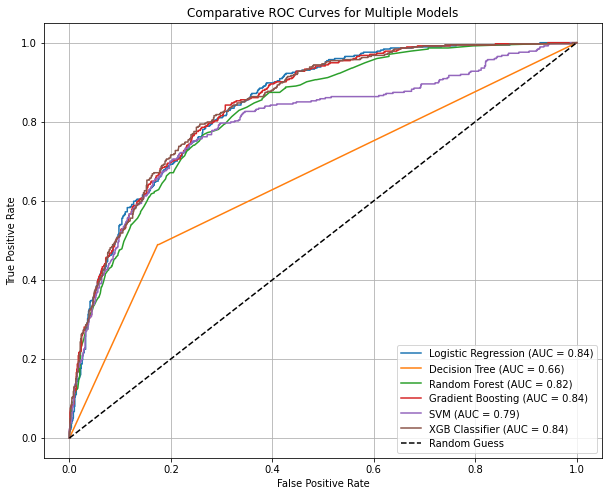

In [14]:
#ROU
plt.figure(figsize=(10, 8))
for name,y_proba in AUC :
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    auc = roc_auc_score(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {auc:.2f})')
    
plt.plot([0, 1], [0, 1], 'k--', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Comparative ROC Curves for Multiple Models')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


# Tuning Models

## Logistic Regression

In [15]:
# Define parameter grid for Logistic Regression
param_grid = {
    'C': [-4,0.01, 0.1, 1, 10, 100,200,500],
    'penalty': ['l1', 'l2','elasticnet','none'],
    'solver': ['liblinear','lbfgs']  # 'liblinear' supports both l1 and l2 penalties
}
# Initialize Logistic Regression with class_weight='balanced'
log_reg = LogisticRegression(class_weight='balanced', max_iter=1000)


# Perform GridSearchCV
grid_search = GridSearchCV(log_reg, param_grid, cv=5, scoring='recall')
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5, error_score=nan,
             estimator=LogisticRegression(C=1.0, class_weight='balanced',
                                          dual=False, fit_intercept=True,
                                          intercept_scaling=1, l1_ratio=None,
                                          max_iter=1000, multi_class='auto',
                                          n_jobs=None, penalty='l2',
                                          random_state=None, solver='lbfgs',
                                          tol=0.0001, verbose=0,
                                          warm_start=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [-4, 0.01, 0.1, 1, 10, 100, 200, 500],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['liblinear', 'lbfgs']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='recall', verbose=0)

In [16]:
# Get the best model and evaluate on test set
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_proba)

print("Best Parameters:", grid_search.best_params_)
print(f"ROC AUC Score of Best Model: {roc_auc:.4f}")
showMetrics("Logistic Regression Tuned",y_test, y_pred)

Best Parameters: {'C': 1, 'penalty': 'l1', 'solver': 'liblinear'}
ROC AUC Score of Best Model: 0.8419
Accuracy : 0.7374024130589071
Precision : 0.5034129692832765
Recall : 0.7887700534759359
F1-score : 0.6145833333333334


## Tune SVM model

In [26]:
# Define parameter grid
param_grid = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf', 'poly'],
     'kernel': ['linear', 'rbf'],
    'gamma': ['scale', 'auto', 0.01, 1],
    'degree': [2, 3, 4]  
}
# Initialize SVM
svc = SVC(class_weight='balanced',probability=True)

random_search = RandomizedSearchCV(
    estimator=svc,
    param_distributions=param_grid,
    n_iter=50,
    scoring='recall',
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42
)
random_search.fit(X_train, y_train)

# Best parameters and score
print("Best Parameters:for SVM Random search", random_search.best_params_)
print("Best F1 Score:", random_search.best_score_)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.2min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 15.6min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed: 24.8min finished


Best Parameters:for SVM Random search {'kernel': 'linear', 'gamma': 0.01, 'degree': 2, 'C': 0.1}
Best F1 Score: 0.8354515050167224


In [27]:
# Grid search
param_grid = {
    'C': [0.1, 1],
    'kernel': ['linear'],    
    'gamma': [0.01,0.1],
    'degree': [1,2,3]  
}
# Initialize SVM
svc = SVC(class_weight='balanced',probability=True)
grid_search = GridSearchCV(svc, param_grid, cv=5, scoring='recall', n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)
# Best parameters and score
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:  4.5min finished


Best Parameters: {'C': 0.1, 'degree': 1, 'gamma': 0.01, 'kernel': 'linear'}
Best F1 Score: 0.8354515050167224


In [28]:
#evaulating model
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_proba)
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))
showMetrics("SVM Tuned with Grid",y_test, y_pred)
print(f"ROC AUC Score of Best Model: {roc_auc:.4f}")

              precision    recall  f1-score   support

           0       0.91      0.65      0.76      1035
           1       0.46      0.82      0.59       374

    accuracy                           0.69      1409
   macro avg       0.68      0.73      0.67      1409
weighted avg       0.79      0.69      0.71      1409

Accuracy : 0.6941092973740242
Precision : 0.45752608047690013
Recall : 0.820855614973262
F1-score : 0.5875598086124402
ROC AUC Score of Best Model: 0.8329


## Tune XBG Classifier

In [19]:
xgb = XGBClassifier(
    objective='binary:logistic',  
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'        
)

param_grid = {
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5],
    'min_child_weight': [1, 3, 5],
    'subsample': [0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'gamma': [0, 0.1, 0.2],
    'n_estimators': [100, 200, 300]  
}

random_search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_grid,
    n_iter=30,       
    scoring='recall',
    cv=5,
    n_jobs=-1,
    random_state=42,
    verbose=2
)
random_search.fit(X_train, y_train)

print("Best Parameters:", random_search.best_params_)
print("Best F1 Score:", random_search.best_score_)

Fitting 5 folds for each of 30 candidates, totalling 150 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   42.4s
[Parallel(n_jobs=-1)]: Done 150 out of 150 | elapsed:  3.0min finished


Best Parameters: {'subsample': 0.7, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.7}
Best F1 Score: 0.5250836120401338


In [20]:
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_proba)

print(classification_report(y_test, y_pred))
showMetrics("XGBClassifier Tuned",y_test, y_pred)
print(f"ROC AUC Score of Best Model: {roc_auc:.4f}")

              precision    recall  f1-score   support

           0       0.84      0.90      0.87      1035
           1       0.65      0.53      0.58       374

    accuracy                           0.80      1409
   macro avg       0.74      0.71      0.73      1409
weighted avg       0.79      0.80      0.79      1409

Accuracy : 0.7991483321504613
Precision : 0.6482084690553745
Recall : 0.5320855614973262
F1-score : 0.5844346549192364
ROC AUC Score of Best Model: 0.8367


In [23]:
#Now tuning with Gridsearch based on Randomsearch parameters.
xgb = XGBClassifier(
    objective='binary:logistic',  # for binary classification
    random_state=42,
    use_label_encoder=False,
    eval_metric='logloss'         # avoids warning for new XGBoost versions
)

# Parameter grid
param_grid = {
    'n_estimators': [200,250],
    'learning_rate': [0.1],
    'max_depth': [1,2],
    'subsample': [0.4,0.5,0.7],
    'colsample_bytree': [0.7],
    'min_child_weight': [1],
    'gamma': [0.1] 
}

grid_search = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    scoring='recall',   
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train, y_train)
print("Best Parameters:", grid_search.best_params_)
print("Best F1 Score:", grid_search.best_score_)


Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:   18.2s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   29.0s finished


Best Parameters: {'colsample_bytree': 0.7, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 250, 'subsample': 0.5}
Best F1 Score: 0.5404682274247491


Notes : 
    Random search Best Parameters: 
    {'subsample': 0.7, 'n_estimators': 300, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.7}
1. Grid search response with reduced paramaetrs: 
    {'colsample_bytree': 0.7, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 250, 'subsample': 0.5}
2. Grid search by reducing estimators and mas_depth. fixing other parametets. scoring as "recall" :
    Best Parameters: {'colsample_bytree': 0.7, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 2, 'min_child_weight': 1, 'n_estimators': 250, 'subsample': 0.5}
    ** consistent with random and grid search

In [25]:
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]
roc_auc = roc_auc_score(y_test, y_proba)
print(classification_report(y_test, y_pred))
showMetrics("XGBClassifier Tuned with Gridsearch",y_test, y_pred)
print(f"ROC AUC Score of Best Model: {roc_auc:.4f}")

              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.67      0.51      0.57       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.72      1409
weighted avg       0.79      0.80      0.79      1409

Accuracy : 0.801277501774308
Precision : 0.6654929577464789
Recall : 0.5053475935828877
F1-score : 0.5744680851063829
ROC AUC Score of Best Model: 0.8451


# Conclusion